In [15]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import time
import torch.optim as optim
import torch.nn as nn

# Define the Pose Estimation Model
class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class ObjectDataset(Dataset):
    def __init__(self, data_2d_path, data_3d_path):
        self.data_2d = []
        self.data_3d = []
        self.expected_output_size = 31  # Expected output size based on the structure provided

        # Get list of files in the 2D directory, assuming corresponding 3D files have the same names
        files_2d = sorted([f for f in os.listdir(data_2d_path) if f.endswith('.csv')])

        for file_2d in files_2d:
            data_2d_file_path = os.path.join(data_2d_path, file_2d)
            data_3d_file_path = os.path.join(data_3d_path, file_2d)  # Corresponding 3D file path

            # Check if the corresponding 3D file exists
            if not os.path.exists(data_3d_file_path):
                print(f"Skipping pair; 3D file missing for: {file_2d}")
                continue

            try:
                # Load 2D and 3D data
                df_2d = pd.read_csv(data_2d_file_path, header=None)
                df_3d = pd.read_csv(data_3d_file_path, header=None)

                # Ensure both files have the same number of rows
                if len(df_2d) != len(df_3d):
                    print(f"Skipping pair; row count mismatch in files: {file_2d}")
                    continue

                # Verify that 3D data rows match the expected output size of 31
                if df_3d.shape[1] != self.expected_output_size:
                    print(f"Warning: Skipping file {file_2d} as 3D data does not match expected size of 31 (found {df_3d.shape[1]})")
                    continue

                # Append each row (object) as a separate entry in the dataset
                for row_2d, row_3d in zip(df_2d.values, df_3d.values):
                    self.data_2d.append(torch.tensor(row_2d, dtype=torch.float32))
                    self.data_3d.append(torch.tensor(row_3d, dtype=torch.float32))

            except (pd.errors.EmptyDataError, ValueError):
                print(f"Skipping invalid file pair: {file_2d}")

    def __len__(self):
        return len(self.data_2d)

    def __getitem__(self, idx):
        return self.data_2d[idx], self.data_3d[idx]

# Define the validation function
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(data_loader)

# Define the training function with logging and model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)

    # Display training start message with total object count
    total_objects = len(train_loader.dataset) + len(val_loader.dataset)
    print("\n" + "="*50)
    print(f"Training Start - Total Objects in Dataset: {total_objects}")
    print("="*50 + "\n")

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model weights after training
    model_save_path = "pose_estimation_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"\nModel weights saved to {model_save_path}")

# Adjusted input_size to match the actual feature count in your data
input_size = 21 
output_size = 31
learning_rate = 0.001
num_epochs = 10

# Instantiate model, loss function, and optimizer
model = PoseEstimationNet(input_size=input_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Paths to the data directories
data_2d_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data\\0_test\\2d_data"
data_3d_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data\\0_test\\3d_data"

# Instantiate dataset and split into training and validation
object_dataset = ObjectDataset(data_2d_path, data_3d_path)

train_size = int(0.8 * len(object_dataset))
val_size = len(object_dataset) - train_size
train_dataset, val_dataset = random_split(object_dataset, [train_size, val_size])

# Instantiate DataLoader with individual objects as samples
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Skipping invalid file pair: 0.csv
Skipping invalid file pair: 16.csv

Training Start - Total Objects in Dataset: 47

Epoch [1/10] - Time: 0.01s, Training Loss: 6.7984, Validation Loss: 7.2785
Epoch [2/10] - Time: 0.01s, Training Loss: 5.7258, Validation Loss: 7.0397
Epoch [3/10] - Time: 0.01s, Training Loss: 4.9580, Validation Loss: 6.6560
Epoch [4/10] - Time: 0.01s, Training Loss: 3.2347, Validation Loss: 6.1475
Epoch [5/10] - Time: 0.01s, Training Loss: 2.4413, Validation Loss: 5.5105
Epoch [6/10] - Time: 0.01s, Training Loss: 1.9406, Validation Loss: 4.7742
Epoch [7/10] - Time: 0.01s, Training Loss: 1.4213, Validation Loss: 4.0610
Epoch [8/10] - Time: 0.01s, Training Loss: 1.2065, Validation Loss: 3.3396
Epoch [9/10] - Time: 0.01s, Training Loss: 0.9173, Validation Loss: 2.7738
Epoch [10/10] - Time: 0.01s, Training Loss: 0.9805, Validation Loss: 2.3444

Model weights saved to pose_estimation_model.pth


In [22]:
import torch
import pandas as pd

# Define the function to load the trained model and use it for inference
def load_model_and_predict_3d(data_2d_path, model_path="pose_estimation_model.pth", input_size=21, output_size=31):
    # Instantiate the model architecture and load weights
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode

    # Load the 2D data for inference
    try:
        df_2d = pd.read_csv(data_2d_path, header=None)
        df_2d = df_2d
        data_2d_tensor = torch.tensor(df_2d.values, dtype=torch.float32)
    except Exception as e:
        print(f"Error loading or processing 2D data: {e}")
        return None

    # Run the model to predict 3D points
    with torch.no_grad():
        predictions_3d = model(data_2d_tensor)
    
    return predictions_3d

# Example usage
data_2d_sample_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data\\0_test\\2d_data\\7.csv"
predictions_3d = load_model_and_predict_3d(data_2d_sample_path)

C:\Users\sakar\AppData\Local\Temp\ipykernel_5368\1122597722.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


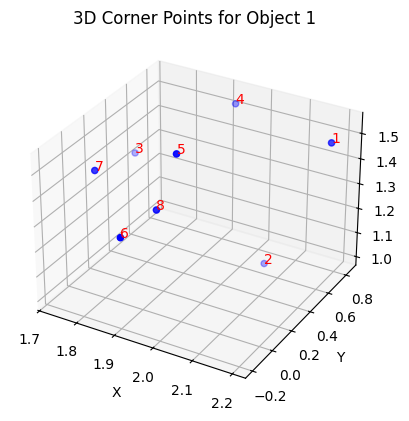

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot 3D corner points from predictions
def plot_3d_corners(predictions_3d):
    # Check if predictions are available
    if predictions_3d is None:
        print("No predictions to plot.")
        return
    
    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    # Plot each object’s corners in a 3D space
    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        # Annotate each corner for clarity
        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j+1}", color="red")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points for Object {i+1}")
        plt.show()

# Plot the 3D corners from the predictions
plot_3d_corners(predictions_3d)
